In [37]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import sys
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

sys.path.insert(0, "..")


In [38]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

# Cargar el DataFrame desde el archivo JSON
df = pd.read_json('../data/processed/realData.json', orient='records', lines=True)

# Convertir las listas de coordenadas en arrays numpy
df['cop_x'] = df['cop_x'].apply(lambda x: np.array(x))
df['cop_y'] = df['cop_y'].apply(lambda x: np.array(x))

# Combinar las columnas de coordenadas en una sola entrada
X_cop_x = np.array(df['cop_x'].tolist())
X_cop_y = np.array(df['cop_y'].tolist())
X = np.stack((X_cop_x, X_cop_y), axis=-1)

# Convertir las etiquetas a números
label_map = {'Healthy': 0, 'Diabetic': 1, 'Neuropathic': 2}
y = df['class'].map(label_map).values

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba basado en las tres clases originales
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_index, test_index = next(sss.split(X, y))
X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

# Conteo de clases en y_train y y_test
print("Conteo de clases en y_train:")
print(pd.Series(y_train).value_counts())

print("\nConteo de clases en y_test:")
print(pd.Series(y_test).value_counts())

# Definir las etiquetas binarias: 0 para sano (Healthy), 1 para diabético/neuropático (Diabetic o Neuropathic)
y_train_binary = np.where(y_train == 0, 0, 1)
y_test_binary = np.where(y_test == 0, 0, 1)

# Conteo de clases en y_train_binary y y_test_binary
print("\nConteo de clases en y_train_binary:")
print(pd.Series(y_train_binary).value_counts())

print("\nConteo de clases en y_test_binary:")
print(pd.Series(y_test_binary).value_counts())

# Verificar las dimensiones de los conjuntos de datos
print("\nShape de X_train:", X_train.shape)
print("Shape de X_test:", X_test.shape)
print("Shape de y_train_binary:", y_train_binary.shape)
print("Shape de y_test_binary:", y_test_binary.shape)



Conteo de clases en y_train:
2    141
1    101
0     61
Name: count, dtype: int64

Conteo de clases en y_test:
2    60
1    44
0    26
Name: count, dtype: int64

Conteo de clases en y_train_binary:
1    242
0     61
Name: count, dtype: int64

Conteo de clases en y_test_binary:
1    104
0     26
Name: count, dtype: int64

Shape de X_train: (303, 500, 2)
Shape de X_test: (130, 500, 2)
Shape de y_train_binary: (303,)
Shape de y_test_binary: (130,)


In [39]:
# Definir la entrada
input_layer = Input(shape=(500, 2))  # Tamaño de las series de tiempo: 500 pasos de tiempo, 2 características (cop_x y cop_y)

# Aplanar los datos de entrada
flatten_layer = Flatten()(input_layer)

# Capa completamente conectada (Dense) con activación relu y dropout
dense1 = Dense(256, activation='relu')(flatten_layer)
dropout1 = Dropout(0.5)(dense1)

# Otra capa densa con activación relu y dropout
dense2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)

# Capa de salida para clasificación binaria sano/diabético-neuropático con activación softmax
output_layer_binary = Dense(2, activation='softmax', name='binary_classification')(dropout2)

# Definir el modelo hasta la primera salida (clasificación binaria)
model_binary = Model(inputs=input_layer, outputs=output_layer_binary)

# Compilar el modelo binario con optimizador Adam y función de pérdida sparse_categorical_crossentropy
model_binary.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Ver el resumen del modelo binario
model_binary.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 500, 2)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       256,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ binary_classification (Dense)   │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289,410 (1.10 MB)

 Trainable params: 289,410 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Entrenar el modelo y guardar el historial
history = model_binary.fit(X_train, y_train_binary, epochs=100, batch_size=32, validation_data=(X_test, y_test_binary))


Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7027 - loss: 0.6624 - val_accuracy: 0.8000 - val_loss: 0.5818
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8014 - loss: 0.5297 - val_accuracy: 0.7538 - val_loss: 0.5827
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8069 - loss: 0.4396 - val_accuracy: 0.7692 - val_loss: 0.5422
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8073 - loss: 0.4371 - val_accuracy: 0.7154 - val_loss: 0.6005
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8385 - loss: 0.3274 - val_accuracy: 0.7385 - val_loss: 0.6388
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8428 - loss: 0.3473 - val_accuracy: 0.7923 - val_loss: 0.6193
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8513 - loss: 0.3179 - val_accuracy: 0.7385 - val_loss: 0.6472
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8638 - loss: 0.2670 - val_accuracy: 0.7769 - 

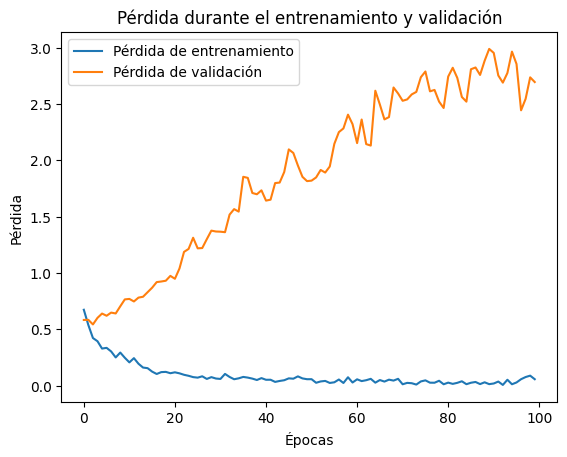

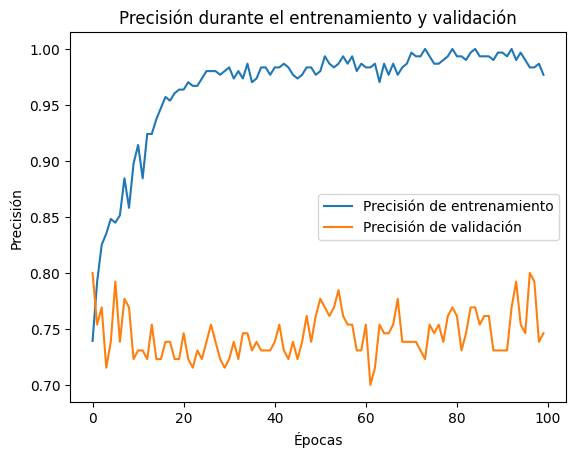

In [41]:
import matplotlib.pyplot as plt

# Plotear la pérdida de entrenamiento y validación
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Plotear la precisión de entrenamiento y validación
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Precisión durante el entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()


In [42]:
from sklearn.metrics import confusion_matrix, classification_report

# Hacer predicciones en los datos de prueba
y_pred_binary = model_binary.predict(X_test)
y_pred_binary_classes = np.argmax(y_pred_binary, axis=1)

# Matriz de confusión
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary_classes)
print('Matriz de confusión:')
print(conf_matrix)

# Reporte de clasificación
class_report = classification_report(y_test_binary, y_pred_binary_classes)
print('Reporte de clasificación:')
print(class_report)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Matriz de confusión:
[[ 7 19]
 [14 90]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.33      0.27      0.30        26
           1       0.83      0.87      0.85       104

    accuracy                           0.75       130
   macro avg       0.58      0.57      0.57       130
weighted avg       0.73      0.75      0.74       130



In [43]:
predictions_train_binary = model_binary.predict(X_train)
predictions_test_binary = model_binary.predict(X_test)

X_train_binary_filtered = X_train[np.isin(y_train, [1, 2])]
y_train_binary_filtered = y_train[np.isin(y_train, [1, 2])]
X_test_binary_filtered = X_test[np.isin(y_test, [1, 2])]
y_test_binary_filtered = y_test[np.isin(y_test, [1, 2])]

input_layer_subclass = Input(shape=(500, 2))
flatten_layer_subclass = Flatten()(input_layer_subclass)
dense1_subclass = Dense(256, activation='relu')(flatten_layer_subclass)
dropout1_subclass = Dropout(0.5)(dense1_subclass)
dense2_subclass = Dense(128, activation='relu')(dropout1_subclass)
dropout2_subclass = Dropout(0.5)(dense2_subclass)
output_layer_subclass = Dense(3, activation='softmax', name='subclass_classification')(dropout2_subclass)  # Salida para 3 clases (Healthy, Diabetic, Neuropathic)

model_subclass = Model(inputs=input_layer_subclass, outputs=output_layer_subclass)

# Compilar el modelo para la clasificación diabético/neuropático
model_subclass.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Ver el resumen del modelo para la clasificación diabético/neuropático
model_subclass.summary()

# Entrenar el modelo para la clasificación diabético/neuropático
history_subclass = model_subclass.fit(X_train_binary_filtered, y_train_binary_filtered, epochs=100, batch_size=32, validation_data=(X_test_binary_filtered, y_test_binary_filtered))



10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 500, 2)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       256,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subclass_classification (Dense) │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289,539 (1.10 MB)

 Trainable params: 289,539 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3384 - loss: 1.3507 - val_accuracy: 0.5865 - val_loss: 0.7632
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6354 - loss: 0.7485 - val_accuracy: 0.6058 - val_loss: 0.7364
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6700 - loss: 0.7553 - val_accuracy: 0.6538 - val_loss: 0.6763
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7178 - loss: 0.6356 - val_accuracy: 0.6442 - val_loss: 0.6817
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7834 - loss: 0.4948 - val_accuracy: 0.6154 - val_loss: 0.6875
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7849 - loss: 0.5092 - val_accuracy: 0.6154 - val_loss: 0.6878
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7764 - loss: 0.4733 - val_accuracy: 0.5769 - val_loss: 0.7199
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8064 - loss: 0.4039 - val_accuracy: 0.6250 - val_loss: 0.7259

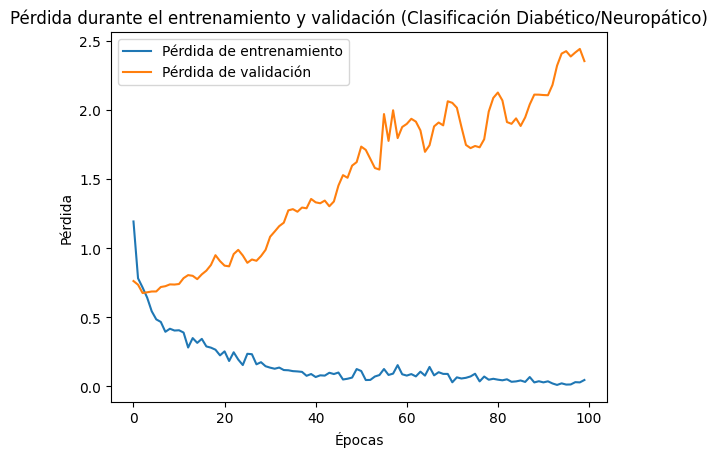

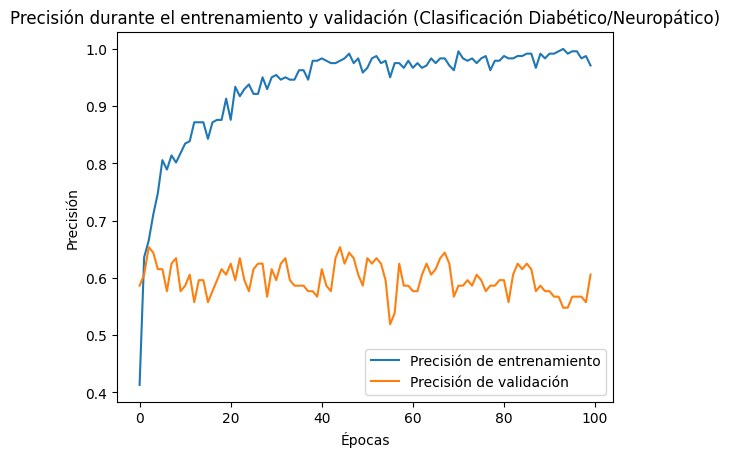

In [44]:
import matplotlib.pyplot as plt

# Plotear la pérdida de entrenamiento y validación
plt.plot(history_subclass.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history_subclass.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento y validación (Clasificación Diabético/Neuropático)')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Plotear la precisión de entrenamiento y validación
plt.plot(history_subclass.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history_subclass.history['val_accuracy'], label='Precisión de validación')
plt.title('Precisión durante el entrenamiento y validación (Clasificación Diabético/Neuropático)')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()


In [45]:
# Evaluar el modelo en los datos de prueba
test_loss_subclass, test_accuracy_subclass = model_subclass.evaluate(X_test_binary_filtered, y_test_binary_filtered)
print(f'Pérdida en el conjunto de prueba (Clasificación Diabético/Neuropático): {test_loss_subclass}')
print(f'Precisión en el conjunto de prueba (Clasificación Diabético/Neuropático): {test_accuracy_subclass}')



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5642 - loss: 2.4362 
Pérdida en el conjunto de prueba (Clasificación Diabético/Neuropático): 2.3556344509124756
Precisión en el conjunto de prueba (Clasificación Diabético/Neuropático): 0.6057692170143127


In [46]:
from sklearn.metrics import confusion_matrix, classification_report

# Hacer predicciones en los datos de prueba
y_pred_subclass = model_subclass.predict(X_test_binary_filtered)
y_pred_subclass_classes = np.argmax(y_pred_subclass, axis=1)

# Matriz de confusión
conf_matrix_subclass = confusion_matrix(y_test_binary_filtered, y_pred_subclass_classes)
print('Matriz de confusión (Clasificación Diabético/Neuropático):')
print(conf_matrix_subclass)

# Reporte de clasificación
class_report_subclass = classification_report(y_test_binary_filtered, y_pred_subclass_classes)
print('Reporte de clasificación (Clasificación Diabético/Neuropático):')
print(class_report_subclass)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Matriz de confusión (Clasificación Diabético/Neuropático):
[[20 24]
 [17 43]]
Reporte de clasificación (Clasificación Diabético/Neuropático):
              precision    recall  f1-score   support

           1       0.54      0.45      0.49        44
           2       0.64      0.72      0.68        60

    accuracy                           0.61       104
   macro avg       0.59      0.59      0.59       104
weighted avg       0.60      0.61      0.60       104



In [47]:


support_1 = np.sum(conf_matrix)
support_2 = np.sum(conf_matrix_subclass)

# Calcular el número total de predicciones correctas
correct_predictions = np.trace(conf_matrix) + np.trace(conf_matrix_subclass)

# Calcular el total de predicciones realizadas por el modelo
total_predictions = support_1 + support_2

# Calcular la precisión general
accuracy = correct_predictions / total_predictions

print(f"Precisión general del modelo: {accuracy:.4f}")


Precisión general del modelo: 0.6838


In [48]:
# Sumar las matrices de confusión para obtener la matriz combinada
combined_conf_matrix = conf_matrix + conf_matrix_subclass

# Calcular las métricas a partir de la matriz de confusión combinada
tn, fp, fn, tp = combined_conf_matrix.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

# Mostrar las métricas
print("Métricas combinadas:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1_score:.2f}")

Métricas combinadas:
Accuracy: 0.68
Precision: 0.76
Recall: 0.81
F1-score: 0.78


In [49]:
#TODO: Preguntar al profesor si esto es un enfoque valido o no
combined_conf_matrix

array([[ 27,  43],
       [ 31, 133]], dtype=int64)